In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# Calibrated parameters
fuel_slope = 0.0624
warmup_penalty = 0.4
fresh_tyre_bonus = -1.5
undercut_duration = 2

traffic_threshold = 18
traffic_prob = 0.4
traffic_loss = 0.6

pit_time = 24
race_laps = 57

base_pace = 100  # use median if you want real value

In [6]:
def tyre_deg(lap, compound, soft_deg=0.13, hard_deg=0.06):
    
    if compound == "SOFT":
        return soft_deg * lap + 0.02 * max(0, lap-10)
    
    if compound == "MEDIUM":
        return 0.08 * lap + 0.05 * max(0, lap-15)
    
    if compound == "HARD":
        return hard_deg * lap

In [8]:
def simulate_lap(tyre_age, compound, fuel_remaining):
    
    tyre_effect = tyre_deg(tyre_age, compound)
    fuel_effect = fuel_slope * fuel_remaining
    
    warmup = warmup_penalty if tyre_age < 2 else 0
    
    traffic = 0
    if tyre_age > traffic_threshold:
        if np.random.rand() < traffic_prob:
            traffic = traffic_loss
    
    noise = np.random.normal(0, 0.25)
    
    lap_time = (
        base_pace
        + tyre_effect
        + fuel_effect
        + warmup
        + traffic
        + noise
    )
    
    return lap_time

In [10]:
def simulate_remaining(
    current_lap,
    tyre_age,
    compound,
    pit_now=False,
    new_compound="HARD"
):
    
    total_time = 0
    fuel_remaining = race_laps - current_lap
    
    if pit_now:
        total_time += pit_time
        compound = new_compound
        tyre_age = 0
    
    for lap in range(current_lap, race_laps):
        
        total_time += simulate_lap(
            tyre_age,
            compound,
            fuel_remaining
        )
        
        tyre_age += 1
        fuel_remaining -= 1
    
    return total_time

In [12]:
def evaluate_decision(current_lap, tyre_age, compound):
    
    runs = 500
    
    pit_times = []
    stay_times = []
    
    for _ in range(runs):
        
        # Option 1: Pit now
        pit_times.append(
            simulate_remaining(
                current_lap,
                tyre_age,
                compound,
                pit_now=True
            )
        )
        
        # Option 2: Stay 1 lap then pit
        first_lap = simulate_lap(
            tyre_age,
            compound,
            race_laps - current_lap
        )
        
        stay_then_pit = (
            first_lap
            + pit_time
            + simulate_remaining(
                current_lap + 1,
                0,
                "HARD",
                pit_now=False
            )
        )
        
        stay_times.append(stay_then_pit)
    
    return np.mean(pit_times), np.mean(stay_times)

In [14]:
ages = range(5, 30)
decision_delta = []

for age in ages:
    
    pit_avg, stay_avg = evaluate_decision(
        current_lap=20,
        tyre_age=age,
        compound="MEDIUM"
    )
    
    decision_delta.append(stay_avg - pit_avg)

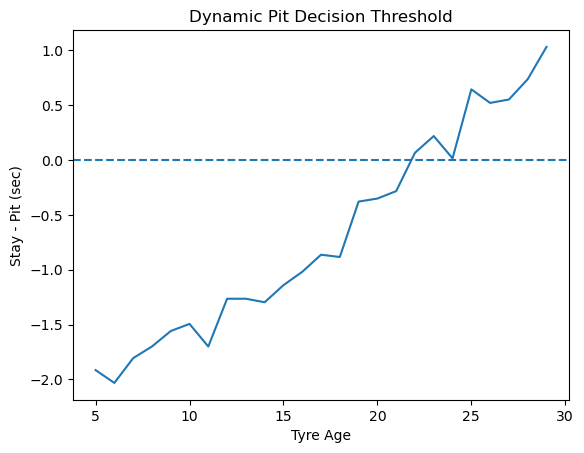

In [16]:
plt.plot(ages, decision_delta)
plt.axhline(0, linestyle="--")

plt.xlabel("Tyre Age")
plt.ylabel("Stay - Pit (sec)")
plt.title("Dynamic Pit Decision Threshold")

plt.show()

In [24]:
lap_range = range(10, 40)
age_range = range(5, 30)

runs = 800  # keep moderate to avoid huge compute

In [26]:
surface = []

for current_lap in lap_range:
    
    row = []
    
    for tyre_age in age_range:
        
        pit_times_list = []
        stay_times_list = []
        
        for _ in range(runs):
            
            # Option 1: Pit Now
            pit_times_list.append(
                simulate_remaining(
                    current_lap,
                    tyre_age,
                    "MEDIUM",
                    pit_now=True
                )
            )
            
            # Option 2: Stay 1 Lap Then Pit
            first_lap = simulate_lap(
                tyre_age,
                "MEDIUM",
                race_laps - current_lap
            )
            
            stay_then_pit = (
                first_lap
                + pit_time
                + simulate_remaining(
                    current_lap + 1,
                    0,
                    "HARD",
                    pit_now=False
                )
            )
            
            stay_times_list.append(stay_then_pit)
        
        delta = np.mean(stay_times_list) - np.mean(pit_times_list)
        
        row.append(delta)
    
    surface.append(row)

surface = np.array(surface)

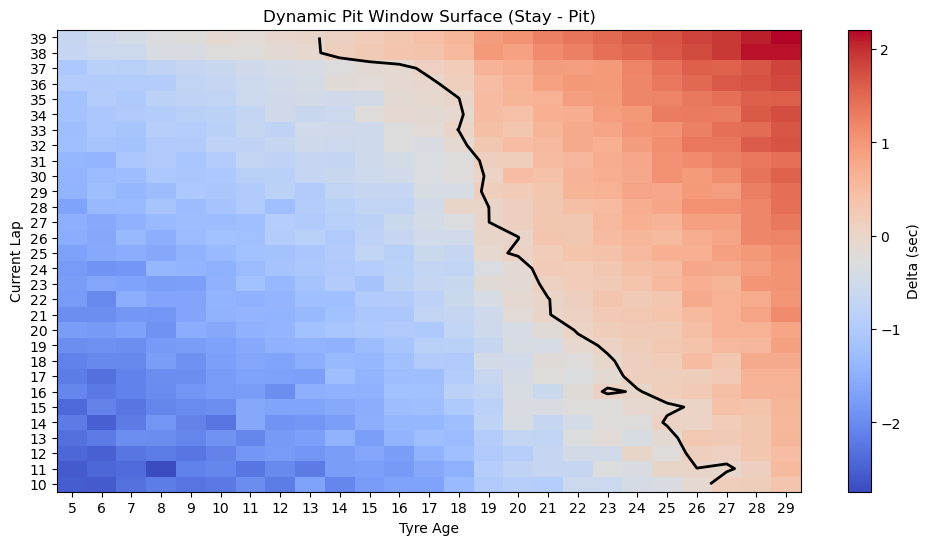

In [27]:
plt.figure(figsize=(12,6))

im = plt.imshow(
    surface,
    aspect="auto",
    origin="lower",
    cmap="coolwarm"
)

plt.xticks(
    range(len(age_range)),
    age_range
)

plt.yticks(
    range(len(lap_range)),
    lap_range
)

plt.xlabel("Tyre Age")
plt.ylabel("Current Lap")
plt.title("Dynamic Pit Window Surface (Stay - Pit)")

plt.colorbar(im, label="Delta (sec)")

plt.contour(surface, levels=[0], colors="black", linewidths=2)

plt.show()